# Create dataset
$\{X,y,C\}$, where $X \in \mathbb{R}^{64x64}$ is the input 2D image, $y \in \mathbb{Z}_2$ is the output label, $C \in \mathbb{R}^{20}$ are the generative attributes of the dataset.
1) Create a base config file:
    1) `COVARS`: Define a dict with all the 'influencial' covariates $\{y,C_{enc}\}$, where $C_{enc} \subset C$, s.t. $c^i \mapsto A , \; \forall c^i \in C_{enc} $
    2) `RULES_COV_TO_GEN`: Define the relationship between the covariates and the generative parameters. 
3) Iteratively increase or decrease a COV_TO_GEN relation and create multiple variations of the base config file.
    1) Define the number of steps of iteration
    2) Define the increment size
3) Test that the config file meets the expectation using `ToyBrainsData(config=...).show_current_config()`
4) Generate the datasets and 3 equivalent test datasets with same .
5) For all images, create an equivalent image with 
5) For all covariates, estimate the maximum predictable accuracy, and decompose it into $y$ driven, $c^i$ driven, $yc^i$-driven
    1) Maximum predictable accuracy: estimated by fitting a linear or logistic regression model directly on the generative attributes using the $R^2$ or $D^2$ metric for goodness-of-fit.
    2) Decompose by evaluating on a no-cov-signal test data and no-true-signal test data.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# print date and time
from datetime import datetime
start_time = datetime.now()
print("Notebook started on {}".format(str(start_time).split(".")[0]))

Notebook started on 2024-02-28 11:14:22


In [2]:
# standard python packages
import os, sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# from tqdm.notebook import tqdm
from copy import deepcopy
from glob import glob
from tqdm.notebook import tqdm

# if parent 'Toybrains' directory is not in path, add it
if os.path.abspath('../../') not in sys.path:
    sys.path.append(os.path.abspath('../../'))

# from create_toybrains import ToyBrainsData
from utils.vizutils import show_contrib_table, viz_contrib_table_2
from utils.genutils import create_config_file, apply_tweak_rules, print_tweaked_rules

### Dataset generation settings

In [3]:
N_SAMPLES  = 1000

GEN_DATASETS = True
OVERWRITE_EXISTING = False
GEN_IMAGES = True
DATASET_SUFFIX = 'test' # '' '-test'

VIZ_DISTS = True
VIZ_IMG_SAMPLES = True 

GEN_BASELINES = False
METRICS = ['r2','balanced_accuracy', 'roc_auc', 'adjusted_mutual_info_score']
VIZ_BASELINE = True # ensure GEN_BASELINES is True or it is pregenerated

STEPS_TRUE = 5
STEPS_CONF = 5

basefilename = 'lblmidr-consite'
config_dirname = 'configs' #  a folder to save all the configs

Define a simple case with 1 binary confound and 1 binary label:

In [4]:
# 1) Create a base config file:
#   a) Define the covariates dict `COVARS`
COVARS = {
            'cov_site'   : dict(states=['siteA', 'siteB']),
            'lbl_lesion' : dict(states=[True, False]),
         }
#   b) Define the covariate to generative parameters relationship `RULES_COV_TO_GEN`
# Rules about which covariate-state influences which generative variables
RULES_COV_TO_GEN = {
    ## (1) c --> X: `siteA -> brain intensity is higher` 
    'cov_site':{
        'siteA':{ 
            'brain-int_fill'  :  dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteA -> more likely to be lesion group` 
            'lbl_lesion' : dict(amt=(1,1))
        },
        'siteB':{
            'brain-int_fill'  : dict(amt=(1,1,1,1,1)),
            ## (2) c --> y: `siteB -> more likely to be control group` 
            'lbl_lesion' : dict(amt=(1,1))
        },
    },
    
    ## (3) X --> y: `lbl_lesion is True -> Volume of mid-right lesion is higher`
    'lbl_lesion':{
        True:{  
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)), 
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
        False:{ 
            'shape-midr_curv'    :dict(amt=(1,1,1,1,1,1,1,1,1)),
            'shape-midr_vol-rad' :dict(amt=(1,1,1,1))},
    },
}

In [5]:
# ! rm -rf configs/*

In [6]:
if not os.path.exists(config_dirname):
    os.makedirs(config_dirname)

Sampling image gen. attributes for n=10 toybrain samples


100%|██████████| 10/10 [00:00<00:00, 487.03it/s]

Config file: configs/lblmidr-consite-dummy.py


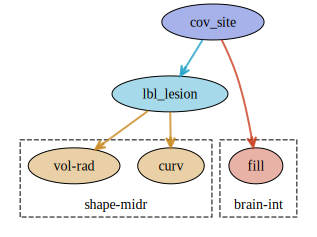

removed 'configs/lblmidr-consite-dummy.py'


In [7]:
if VIZ_DISTS:
    # first create the base config file
    config_fname = f'{config_dirname}/{basefilename}-dummy.py'
        
    # see the base config file's causal graph
    rules = deepcopy(RULES_COV_TO_GEN)
    create_config_file(
                    config_fname, COVARS, rules, 
                    n_samples=10,
                    show_dag=True, show_probas=False,
                    return_baseline_results = False,
                    gen_images=False,
                    overwrite_existing=True)

    # delete the generated config file and dataset
    !rm -v $config_fname

### Define rule updates
Now iteratively generate more config files from the base configuration by:
1. Create 5 steps of increasing true association  $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in steps from 0% -> 25%-> 50% -> 75% -> 100% associations.  
2. Create 5 steps of increasing confound association with the attributes $c_{site} \rightarrow a_{brain-int\_fill}$ from 0 to 100% 
3. Create 5 steps of increasing confound correlation with the output  $c_{site} \rightarrow y_{lesion}$ in 5 steps from 0 to 100% 

In total there should be $5 \times 5 \times 5 = 125$ configurations.

In [8]:
# create a generator that yields 'iter' number of vectors, given the start and the end vector
def linear_interpolate(start, end, iter):
    start = np.array(start)
    end = np.array(end)
    for i in range(iter):
        yield (start + (end-start)*i/(iter-1)).tolist()

In [9]:
# (1) incrementally increasing $y_{lesion} \rightarrow a_{midr\_vol-rad}$ and $y_{lesion} \rightarrow a_{midr\_curv}$ in 5 steps 
# from 0% association to 100% association
curv_start = (1, 1, 1, 1, 1, 1, 1, 1, 1)
curv_end = (0, 0, 0, 0, 0, 1, 1, 2, 5)
vol_rad_start = (1, 1, 1, 1)
vol_rad_end = (0, 0, 1, 3)


tweak_rules_yX =[
    ['lbl_lesion', True,   'shape-midr_curv',    'amt', list(linear_interpolate(curv_start, curv_end, STEPS_TRUE)            )],
    ['lbl_lesion', False,  'shape-midr_curv',    'amt', list(linear_interpolate(curv_start, curv_end[::-1], STEPS_TRUE)      )],
    ['lbl_lesion', True,   'shape-midr_vol-rad', 'amt', list(linear_interpolate(vol_rad_start, vol_rad_end, STEPS_TRUE)      )],
    ['lbl_lesion', False,  'shape-midr_vol-rad', 'amt', list(linear_interpolate(vol_rad_start, vol_rad_end[::-1], STEPS_TRUE))]
]

# test
if VIZ_DISTS:
    print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_yX, iters=STEPS_TRUE)

--------------------------------------------------
i=0
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [1.0, 1.0, 1.0, 1.0]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = [1.0, 1.0, 1.0, 1.0]
--------------------------------------------------
i=1
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [0.75, 0.75, 0.75, 0.75, 0.75, 1.0, 1.0, 1.25, 2.0]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt = [2.0, 1.25, 1.0, 1.0, 0.75, 0.75, 0.75, 0.75, 0.75]
	 lbl_lesion = True 	--> shape-midr_vol-rad:	 amt = [0.75, 0.75, 1.0, 1.5]
	 lbl_lesion = False 	--> shape-midr_vol-rad:	 amt = [1.5, 1.0, 0.75, 0.75]
--------------------------------------------------
i=2
	 lbl_lesion = True 	--> shape-midr_curv:	 amt = [0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.5, 3.0]
	 lbl_lesion = False 	--> shape-midr_curv:	 amt 

In [10]:
# (2) incrementally increasing partial $c_{site} --> a_{brain-int_fill}$ in 5 steps from 0 to 100%
int_fill_start = (1, 1, 1, 1, 1)
int_fill_end   = (0, 0, 0, 1, 4)

tweak_rules_cX =[
    ['cov_site', 'siteA', 'brain-int_fill', 'amt', list(linear_interpolate(int_fill_start, int_fill_end, STEPS_CONF))],
    ['cov_site', 'siteB', 'brain-int_fill', 'amt', list(linear_interpolate(int_fill_start, int_fill_end[::-1], STEPS_CONF))]
]

if VIZ_DISTS:
    print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_cX, iters=STEPS_CONF)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> brain-int_fill:	 amt = [1.0, 1.0, 1.0, 1.0, 1.0]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [1.0, 1.0, 1.0, 1.0, 1.0]
--------------------------------------------------
i=1
	 cov_site = siteA 	--> brain-int_fill:	 amt = [0.75, 0.75, 0.75, 1.0, 1.75]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [1.75, 1.0, 0.75, 0.75, 0.75]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> brain-int_fill:	 amt = [0.5, 0.5, 0.5, 1.0, 2.5]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [2.5, 1.0, 0.5, 0.5, 0.5]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> brain-int_fill:	 amt = [0.25, 0.25, 0.25, 1.0, 3.25]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [3.25, 1.0, 0.25, 0.25, 0.25]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> brain-int_fill:	 amt = [0.0, 0.0, 0.0, 1.0, 4.0]
	 cov_site = siteB 	--> brain-int_fill:	 amt = [4.0,

In [11]:
# (3) incrementally increasing partial $c_{site} --> y_{lesion}$ in 5 steps from 0 to 100% 
lbl_lesion_start = (1, 1)
lbl_lesion_end   = (0, 2)

tweak_rules_cy =[
    ['cov_site', 'siteA', 'lbl_lesion', 'amt', list(linear_interpolate(lbl_lesion_start, lbl_lesion_end, STEPS_CONF))],#lambda x: int((x+1)**2)],
    ['cov_site', 'siteB', 'lbl_lesion', 'amt', list(linear_interpolate(lbl_lesion_start, lbl_lesion_end[::-1], STEPS_CONF))]#lambda x: int((x+1)**2)]
]

if VIZ_DISTS:
    print_tweaked_rules(RULES_COV_TO_GEN, tweak_rules_cy, iters=STEPS_CONF)

--------------------------------------------------
i=0
	 cov_site = siteA 	--> lbl_lesion:	 amt = [1.0, 1.0]
	 cov_site = siteB 	--> lbl_lesion:	 amt = [1.0, 1.0]
--------------------------------------------------
i=1
	 cov_site = siteA 	--> lbl_lesion:	 amt = [0.75, 1.25]
	 cov_site = siteB 	--> lbl_lesion:	 amt = [1.25, 0.75]
--------------------------------------------------
i=2
	 cov_site = siteA 	--> lbl_lesion:	 amt = [0.5, 1.5]
	 cov_site = siteB 	--> lbl_lesion:	 amt = [1.5, 0.5]
--------------------------------------------------
i=3
	 cov_site = siteA 	--> lbl_lesion:	 amt = [0.25, 1.75]
	 cov_site = siteB 	--> lbl_lesion:	 amt = [1.75, 0.25]
--------------------------------------------------
i=4
	 cov_site = siteA 	--> lbl_lesion:	 amt = [0.0, 2.0]
	 cov_site = siteB 	--> lbl_lesion:	 amt = [2.0, 0.0]


### Generate all rules

In [12]:
# os.system(f"rm -rvf dataset/toybrains_n{N_SAMPLES}_{basefilename}_*") # remove the existing dataset

In [13]:
# collect all the rules
all_rules = []
rules_to_viz = [('no true  &  no conf', (0,0,0)),
                ('FULL true & no conf', (0,0,STEPS_TRUE-1)),
                ('low true & HIGH conf', (1,1,3)),
                ('HIGH true & low conf', (3,3,1)),
                ('no true & FULL conf', (STEPS_CONF-1,STEPS_CONF-1,0))]
rules_to_viz_final = []

for cy in range(STEPS_CONF):
    if cy==0: # reset
        rules_cy = deepcopy(RULES_COV_TO_GEN)
    rules_cy = apply_tweak_rules(rules_cy, tweak_rules_cy, cy)

    for cX in range(STEPS_CONF):
        if cX==0: # reset the rules to previous loop's rules
            rules_cX = deepcopy(rules_cy)
        rules_cX = apply_tweak_rules(rules_cX, tweak_rules_cX, cX)

        for yX in range(STEPS_TRUE):
            if yX==0: # reset the rules to previous loop's rules
                rules_yX = deepcopy(rules_cX)
            rules_yX = apply_tweak_rules(rules_yX, tweak_rules_yX, yX)
            # print(f'cy={cy}, cX={cX}, yX={yX}, {rules_yX["lbl_lesion"][True]["shape-midr_curv"]["amt"]}')
            all_rules.append(((cy, cX, yX), deepcopy(rules_yX)))
            
            for r in rules_to_viz:
                if r[1] == (cy, cX, yX):
                    cy_percent = (100*cy)//(STEPS_CONF-1)
                    cX_percent = (100*cX)//(STEPS_CONF-1)
                    yX_percent = (100*yX)//(STEPS_TRUE-1)
                    rules_to_viz_final.append((r[0], 
                                               (f'{cy_percent:03}', f'{cX_percent:03}',f'{yX_percent:03}'), 
                                               deepcopy(rules_yX)))
                    
        

Configured distributions of the image attributes:
-------------------------------------------------- 	no true  &  no conf	 --------------------------------------------------
cy=000, cX=000, yX=000


100%|██████████| 10/10 [00:00<00:00, 465.96it/s]

Config file: configs/lblmidr-consite_cy000-cX000-yX000-dummy.py


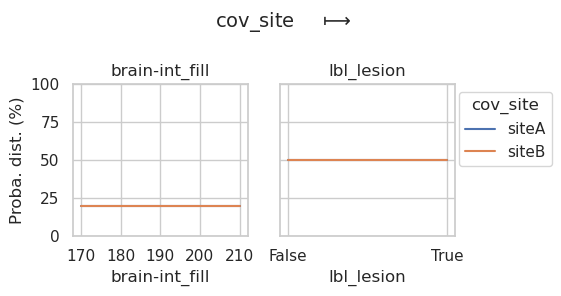

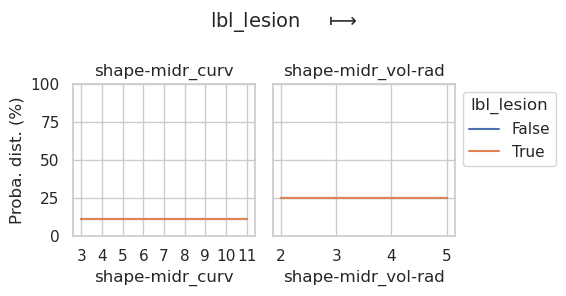

None

-------------------------------------------------- 	FULL true & no conf	 --------------------------------------------------
cy=000, cX=000, yX=100


100%|██████████| 10/10 [00:00<00:00, 482.96it/s]

Config file: configs/lblmidr-consite_cy000-cX000-yX100-dummy.py


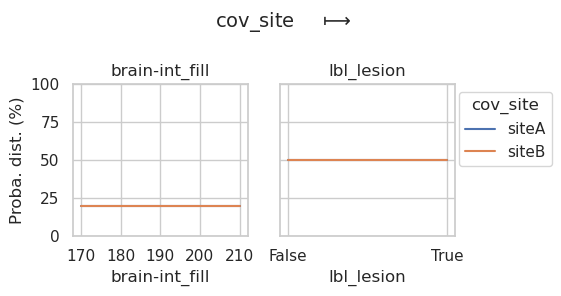

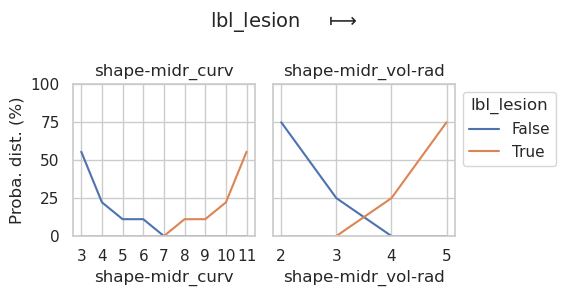

None

-------------------------------------------------- 	low true & HIGH conf	 --------------------------------------------------
cy=025, cX=025, yX=075


100%|██████████| 10/10 [00:00<00:00, 467.94it/s]

Config file: configs/lblmidr-consite_cy025-cX025-yX075-dummy.py


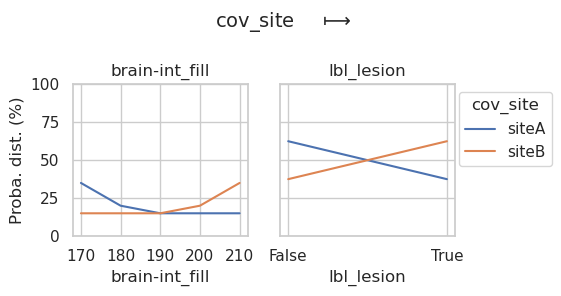

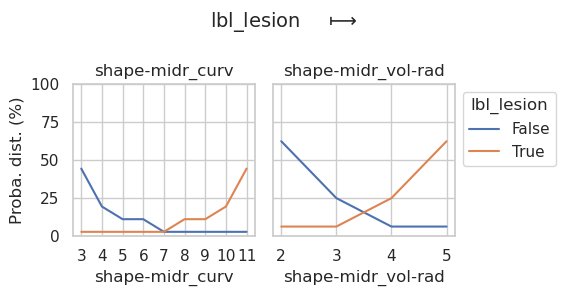

None

-------------------------------------------------- 	HIGH true & low conf	 --------------------------------------------------
cy=075, cX=075, yX=025


100%|██████████| 10/10 [00:00<00:00, 450.57it/s]

Config file: configs/lblmidr-consite_cy075-cX075-yX025-dummy.py


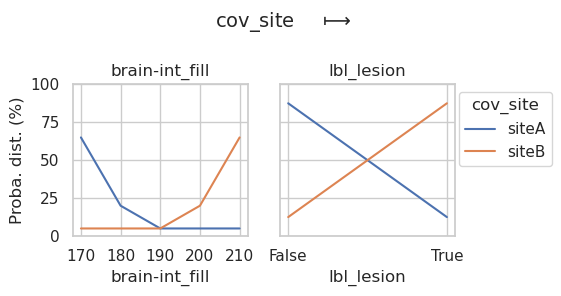

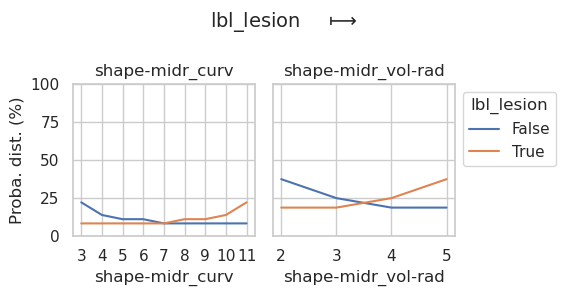

None

-------------------------------------------------- 	no true & FULL conf	 --------------------------------------------------
cy=100, cX=100, yX=000


100%|██████████| 10/10 [00:00<00:00, 455.07it/s]

Config file: configs/lblmidr-consite_cy100-cX100-yX000-dummy.py


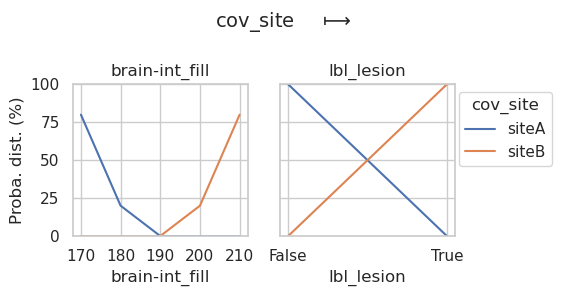

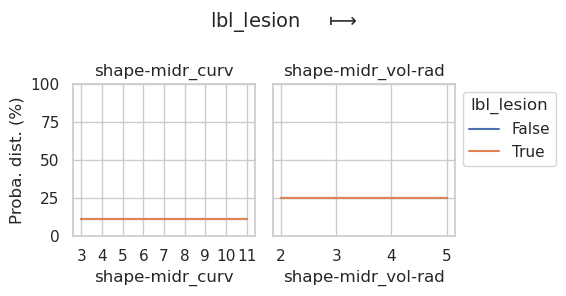

None

In [14]:
if VIZ_DISTS:
    print("Configured distributions of the image attributes:")

    for name, (cy,cX,yX), r in rules_to_viz_final:
        print(f"{'-'*50} \t{name}\t {'-'*50}\ncy={cy}, cX={cX}, yX={yX}")
        config_fname = f'{config_dirname}/{basefilename}_cy{cy}-cX{cX}-yX{yX}-dummy.py'

        # create a toybrains object with the config file
        create_config_file(
                    config_fname, COVARS, deepcopy(r), 
                    show_probas=True, show_dag=False, n_samples=10,
                    return_baseline_results = False,
                    gen_images=False,
                    overwrite_existing=True,
                    verbose=False)
        

In [15]:
# delete the generated config file in the end
! rm -rf configs/*-dummy.py
! rm -rf dataset/toybrains_*-dummy 

### Generate datasets

In [16]:
def create_config_file_parallel(cy,cX,yX, rules, 
                                n_samples=N_SAMPLES, 
                                gen_baselines=GEN_BASELINES, metrics=METRICS,
                                gen_images=GEN_IMAGES, dataset_suffix=DATASET_SUFFIX):
    cy_percent = (100*cy)//(STEPS_CONF-1)
    cX_percent = (100*cX)//(STEPS_CONF-1)
    yX_percent = (100*yX)//(STEPS_TRUE-1)
    config_fname = f'{config_dirname}/{basefilename}_cy{cy_percent:03}-cX{cX_percent:03}-yX{yX_percent:03}.py'
    print(f'Creating dataset with config file {config_fname}')
    
    # TODO: only generate images for one mid subset of settings to save time
    # if gen_images==True and cX==2: 
    #     gen_images = True
    # else:
    #     gen_images = False
        
    bl_result = create_config_file(
                    config_fname, COVARS, rules, 
                    dataset_suffix=dataset_suffix,
                    return_baseline_results=gen_baselines,
                    baseline_metrics=metrics,
                    n_samples=n_samples,
                    gen_images=gen_images,
                    verbose=0,
                    overwrite_existing=OVERWRITE_EXISTING)
    return bl_result

In [17]:
# test SHAP estimation
# (cy,cX,yX), rules = all_rules[-1]
# results = create_config_file_parallel(cy,cX,yX, rules)

In [18]:
# delete previously generated dataset
# os.system(f"rm -rvf dataset/toybrains_n{N_SAMPLES}_{basefilename}_*") # stop da

In [19]:
# ask the runner if they really want to regenerate the datasets?
if GEN_DATASETS:
    print(f"Do you really want to regenerate the datasets under 'dataset/{basefilename}*{DATASET_SUFFIX}' for all the configurations? (y/n)")
    ans = input()
    if ans.lower() != 'y':
        GEN_DATASETS = False

    print("answered '{}'. Set GEN_DATASETS to {}".format(ans, GEN_DATASETS))

Do you really want to regenerate the datasets under 'dataset/lblmidr-consite*test' for all the configurations? (y/n)
answered 'y'. Set GEN_DATASETS to True


In [20]:
# parallelize the generation of configs using joblib
from joblib import Parallel, delayed

if GEN_DATASETS:
    bl_results = Parallel(
        n_jobs=25, verbose=0)(
                            delayed(
                                create_config_file_parallel)(
                                    cy,cX,yX, r) for (cy,cX,yX), r in tqdm(all_rules))


  0%|          | 0/125 [00:00<?, ?it/s]

Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX050.py
Config file 'configs/lblmidr-consite_cy000-cX025-yX050.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]06.49it/s]]

Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX000.py
Config file 'configs/lblmidr-consite_cy000-cX025-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX075.py
Config file 'configs/lblmidr-consite_cy000-cX000-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX075.py
Config file 'configs/lblmidr-consite_cy000-cX025-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX050.py
Config file 'configs/lblmidr-consite_cy000-cX000-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX025.py
Config file 'configs/lblmidr-consite_cy000-cX025-yX025.py' already exists. Not overwriting it.


  8%|▊         | 77/1000 [00:00<00:02, 389.23it/s]]

Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX000.py
Config file 'configs/lblmidr-consite_cy000-cX100-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX000.py
Config file 'configs/lblmidr-consite_cy000-cX050-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX050.py
Config file 'configs/lblmidr-consite_cy000-cX050-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX100.py
Config file 'configs/lblmidr-consite_cy000-cX100-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX000.py
Config file 'configs/lblmidr-consite_cy000-cX000-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX000.py
Config file 'configs/lblmidr-consite_cy000-cX075-yX

  9%|▉         | 92/1000 [00:00<00:01, 468.24it/s]]

Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX025.py
Config file 'configs/lblmidr-consite_cy000-cX075-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX075.py
Config file 'configs/lblmidr-consite_cy000-cX075-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX025-yX100.py
Config file 'configs/lblmidr-consite_cy000-cX025-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX000-yX025.py
Config file 'configs/lblmidr-consite_cy000-cX000-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX050-yX025.py
Config file 'configs/lblmidr-consite_cy000-cX050-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX050.py
Config file 'configs/lblmidr-consite_cy000-cX100-yX

  3%|▎         | 29/1000 [00:00<00:03, 280.81it/s]]

Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX100.py
Config file 'configs/lblmidr-consite_cy000-cX075-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy000-cX075-yX050.py
Config file 'configs/lblmidr-consite_cy000-cX075-yX050.py' already exists. Not overwriting it.


 14%|█▍        | 145/1000 [00:00<00:02, 287.32it/s]

Creating dataset with config file configs/lblmidr-consite_cy000-cX100-yX075.py
Config file 'configs/lblmidr-consite_cy000-cX100-yX075.py' already exists. Not overwriting it.


 37%|███▋      | 373/1000 [00:01<00:02, 271.27it/s]

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]260.06it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:02<00:00, 429.37it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 76%|███████▋  | 764/1000 [00:02<00:00, 325.78it/s]

Generating n=1000 toybrain images


 83%|████████▎ | 833/1000 [00:02<00:00, 334.49it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 83%|████████▎ | 833/1000 [00:02<00:00, 278.55it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]354.03it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 93%|█████████▎| 929/1000 [00:03<00:00, 370.08it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:03<00:00, 294.14it/s]


Generating n=1000 toybrain imagesGenerating n=1000 toybrain images

Generating n=1000 toybrain images


  8%|▊         | 80/1000 [00:02<00:28, 32.29it/s]

Generating n=1000 toybrain images


  3%|▎         | 28/1000 [00:00<00:03, 279.00it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX000.py
Config file 'configs/lblmidr-consite_cy025-cX000-yX000.py' already exists. Not overwriting it.


 24%|██▍       | 239/1000 [00:01<00:03, 216.02it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX025.py
Config file 'configs/lblmidr-consite_cy025-cX000-yX025.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]257.84it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX050.py
Config file 'configs/lblmidr-consite_cy025-cX000-yX050.py' already exists. Not overwriting it.


  4%|▎         | 37/1000 [00:00<00:02, 366.83it/s]]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX075.py
Config file 'configs/lblmidr-consite_cy025-cX000-yX075.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]321.30it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX000-yX100.py
Config file 'configs/lblmidr-consite_cy025-cX000-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX000.py
Config file 'configs/lblmidr-consite_cy025-cX025-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX025.py
Config file 'configs/lblmidr-consite_cy025-cX025-yX025.py' already exists. Not overwriting it.


  8%|▊         | 78/1000 [00:00<00:02, 365.25it/s]]

Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX050.py
Config file 'configs/lblmidr-consite_cy025-cX025-yX050.py' already exists. Not overwriting it.


 43%|████▎     | 428/1000 [00:01<00:01, 297.88it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX075.py
Config file 'configs/lblmidr-consite_cy025-cX025-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX025-yX100.py
Config file 'configs/lblmidr-consite_cy025-cX025-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX000.py
Config file 'configs/lblmidr-consite_cy025-cX050-yX000.py' already exists. Not overwriting it.


 85%|████████▍ | 848/1000 [00:03<00:00, 273.47it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX025.py
Config file 'configs/lblmidr-consite_cy025-cX050-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX050.py
Config file 'configs/lblmidr-consite_cy025-cX050-yX050.py' already exists. Not overwriting it.


 41%|████      | 412/1000 [00:01<00:01, 322.24it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX075.py
Config file 'configs/lblmidr-consite_cy025-cX050-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX050-yX100.py
Config file 'configs/lblmidr-consite_cy025-cX050-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX000.py
Config file 'configs/lblmidr-consite_cy025-cX075-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX025.py
Config file 'configs/lblmidr-consite_cy025-cX075-yX025.py' already exists. Not overwriting it.


 48%|████▊     | 478/1000 [00:01<00:01, 322.19it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX050.py
Config file 'configs/lblmidr-consite_cy025-cX075-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX075.py
Config file 'configs/lblmidr-consite_cy025-cX075-yX075.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy025-cX075-yX100.py
Config file 'configs/lblmidr-consite_cy025-cX075-yX100.py' already exists. Not overwriting it.


  3%|▎         | 28/1000 [00:00<00:03, 276.82it/s]]

Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX000.py
Config file 'configs/lblmidr-consite_cy025-cX100-yX000.py' already exists. Not overwriting it.


 23%|██▎       | 233/1000 [00:00<00:02, 375.22it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX025.py
Config file 'configs/lblmidr-consite_cy025-cX100-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX050.py
Config file 'configs/lblmidr-consite_cy025-cX100-yX050.py' already exists. Not overwriting it.


 18%|█▊        | 185/1000 [00:00<00:01, 452.12it/s]

Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX075.py
Config file 'configs/lblmidr-consite_cy025-cX100-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy025-cX100-yX100.py
Config file 'configs/lblmidr-consite_cy025-cX100-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images


 50%|████▉     | 497/1000 [00:01<00:01, 419.31it/s]

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]356.94it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 31%|███       | 306/1000 [00:01<00:02, 286.04it/s]

Generating n=1000 toybrain images


 84%|████████▎ | 837/1000 [00:02<00:00, 312.54it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 61%|██████    | 612/1000 [00:01<00:01, 321.30it/s]

Generating n=1000 toybrain images


 87%|████████▋ | 872/1000 [00:02<00:00, 262.06it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:02<00:00, 342.42it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


  8%|▊         | 80/1000 [00:02<00:23, 39.21it/s]s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]335.67it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


  3%|▎         | 32/1000 [00:00<00:03, 313.93it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX000.py
Config file 'configs/lblmidr-consite_cy050-cX000-yX000.py' already exists. Not overwriting it.


  4%|▎         | 37/1000 [00:00<00:02, 360.27it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX025.py
Config file 'configs/lblmidr-consite_cy050-cX000-yX025.py' already exists. Not overwriting it.


 10%|▉         | 96/1000 [00:00<00:05, 165.08it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX050.py
Config file 'configs/lblmidr-consite_cy050-cX000-yX050.py' already exists. Not overwriting it.


 15%|█▌        | 153/1000 [00:00<00:03, 215.47it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX075.py
Config file 'configs/lblmidr-consite_cy050-cX000-yX075.py' already exists. Not overwriting it.


 18%|█▊        | 180/1000 [00:00<00:03, 269.26it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX000-yX100.py
Config file 'configs/lblmidr-consite_cy050-cX000-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX000.py
Config file 'configs/lblmidr-consite_cy050-cX025-yX000.py' already exists. Not overwriting it.


 40%|████      | 400/1000 [00:01<00:02, 245.76it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX025.py
Config file 'configs/lblmidr-consite_cy050-cX025-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX050.py
Config file 'configs/lblmidr-consite_cy050-cX025-yX050.py' already exists. Not overwriting it.


 42%|████▏     | 417/1000 [00:01<00:01, 302.84it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX075.py
Config file 'configs/lblmidr-consite_cy050-cX025-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX025-yX100.py
Config file 'configs/lblmidr-consite_cy050-cX025-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX000.py
Config file 'configs/lblmidr-consite_cy050-cX050-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX025.py
Config file 'configs/lblmidr-consite_cy050-cX050-yX025.py' already exists. Not overwriting it.


 12%|█▏        | 120/1000 [00:00<00:02, 388.39it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX050.py
Config file 'configs/lblmidr-consite_cy050-cX050-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX075.py
Config file 'configs/lblmidr-consite_cy050-cX050-yX075.py' already exists. Not overwriting it.


 80%|███████▉  | 797/1000 [00:03<00:00, 241.66it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX050-yX100.py
Config file 'configs/lblmidr-consite_cy050-cX050-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX000.py
Config file 'configs/lblmidr-consite_cy050-cX075-yX000.py' already exists. Not overwriting it.


  4%|▍         | 40/1000 [00:00<00:02, 392.62it/s]]

Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX025.py
Config file 'configs/lblmidr-consite_cy050-cX075-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX050.py
Config file 'configs/lblmidr-consite_cy050-cX075-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX075.py
Config file 'configs/lblmidr-consite_cy050-cX075-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX075-yX100.py
Config file 'configs/lblmidr-consite_cy050-cX075-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX000.py
Config file 'configs/lblmidr-consite_cy050-cX100-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX025.py
Config file 'configs/lblmidr-consite_cy050-cX100-yX

 16%|█▌        | 159/1000 [00:00<00:02, 408.65it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


 34%|███▎      | 336/1000 [00:00<00:01, 382.73it/s]

Creating dataset with config file configs/lblmidr-consite_cy050-cX100-yX100.py
Config file 'configs/lblmidr-consite_cy050-cX100-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 73%|███████▎  | 729/1000 [00:02<00:01, 259.07it/s]

Generating n=1000 toybrain images


 46%|████▌     | 462/1000 [00:01<00:01, 369.91it/s]

Generating n=1000 toybrain images


 92%|█████████▏| 921/1000 [00:03<00:00, 258.69it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:03<00:00, 324.47it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 98%|█████████▊| 984/1000 [00:03<00:00, 249.55it/s]

Generating n=1000 toybrain images


 96%|█████████▋| 965/1000 [00:02<00:00, 318.85it/s]

Generating n=1000 toybrain images


 92%|█████████▎| 925/1000 [00:02<00:00, 288.92it/s]

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]282.74it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 89%|████████▉ | 888/1000 [00:02<00:00, 337.38it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:03<00:00, 325.14it/s]


Generating n=1000 toybrain images


100%|██████████| 1000/1000 [01:16<00:00, 13.10it/s]



Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX000.py
Config file 'configs/lblmidr-consite_cy075-cX000-yX000.py' already exists. Not overwriting it.


  3%|▎         | 26/1000 [00:00<00:03, 253.08it/s]]

Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX025.py
Config file 'configs/lblmidr-consite_cy075-cX000-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX050.py
Config file 'configs/lblmidr-consite_cy075-cX000-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX075.py
Config file 'configs/lblmidr-consite_cy075-cX000-yX075.py' already exists. Not overwriting it.


  3%|▎         | 28/1000 [00:00<00:03, 271.09it/s]]

Creating dataset with config file configs/lblmidr-consite_cy075-cX000-yX100.py
Config file 'configs/lblmidr-consite_cy075-cX000-yX100.py' already exists. Not overwriting it.


  4%|▍         | 38/1000 [00:00<00:02, 378.57it/s]]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX000.py
Config file 'configs/lblmidr-consite_cy075-cX025-yX000.py' already exists. Not overwriting it.


 20%|█▉        | 199/1000 [00:00<00:02, 273.41it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX025.py
Config file 'configs/lblmidr-consite_cy075-cX025-yX025.py' already exists. Not overwriting it.


 38%|███▊      | 383/1000 [00:01<00:01, 310.46it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX050.py
Config file 'configs/lblmidr-consite_cy075-cX025-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX075.py
Config file 'configs/lblmidr-consite_cy075-cX025-yX075.py' already exists. Not overwriting it.


 60%|█████▉    | 598/1000 [00:01<00:01, 306.42it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX025-yX100.py
Config file 'configs/lblmidr-consite_cy075-cX025-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images


 17%|█▋        | 166/1000 [00:00<00:03, 256.69it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX000.py
Config file 'configs/lblmidr-consite_cy075-cX050-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX025.py
Config file 'configs/lblmidr-consite_cy075-cX050-yX025.py' already exists. Not overwriting it.


 23%|██▎       | 234/1000 [00:00<00:02, 296.84it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX050.py
Config file 'configs/lblmidr-consite_cy075-cX050-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX075.py
Config file 'configs/lblmidr-consite_cy075-cX050-yX075.py' already exists. Not overwriting it.


 52%|█████▏    | 522/1000 [00:01<00:01, 338.88it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX050-yX100.py
Config file 'configs/lblmidr-consite_cy075-cX050-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX000.py
Config file 'configs/lblmidr-consite_cy075-cX075-yX000.py' already exists. Not overwriting it.


 88%|████████▊ | 877/1000 [00:02<00:00, 265.21it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX025.py
Config file 'configs/lblmidr-consite_cy075-cX075-yX025.py' already exists. Not overwriting it.


 99%|█████████▉| 991/1000 [00:03<00:00, 271.20it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX050.py
Config file 'configs/lblmidr-consite_cy075-cX075-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX075.py
Config file 'configs/lblmidr-consite_cy075-cX075-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX075-yX100.py
Config file 'configs/lblmidr-consite_cy075-cX075-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX000.py
Config file 'configs/lblmidr-consite_cy075-cX100-yX000.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]371.90it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX025.py
Config file 'configs/lblmidr-consite_cy075-cX100-yX025.py' already exists. Not overwriting it.
Generating n=1000 toybrain images


 30%|███       | 300/1000 [00:00<00:01, 352.44it/s]

Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX050.py
Config file 'configs/lblmidr-consite_cy075-cX100-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX075.py
Config file 'configs/lblmidr-consite_cy075-cX100-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy075-cX100-yX100.py
Config file 'configs/lblmidr-consite_cy075-cX100-yX100.py' already exists. Not overwriting it.


 17%|█▋        | 169/1000 [00:00<00:03, 264.04it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 58%|█████▊    | 578/1000 [00:02<00:01, 258.09it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


 58%|█████▊    | 576/1000 [00:01<00:01, 323.09it/s]

Generating n=1000 toybrain images


 57%|█████▋    | 573/1000 [00:02<00:01, 219.53it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


 87%|████████▋ | 868/1000 [00:02<00:00, 314.09it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:03<00:00, 306.78it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


  8%|▊         | 80/1000 [00:02<00:32, 28.35it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [01:22<00:00, 12.13it/s]


Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX000.py
Config file 'configs/lblmidr-consite_cy100-cX000-yX000.py' already exists. Not overwriting it.


 29%|██▉       | 292/1000 [00:00<00:02, 288.61it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX025.py
Config file 'configs/lblmidr-consite_cy100-cX000-yX025.py' already exists. Not overwriting it.


  3%|▎         | 32/1000 [00:00<00:03, 312.89it/s]]

Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX050.py
Config file 'configs/lblmidr-consite_cy100-cX000-yX050.py' already exists. Not overwriting it.


  3%|▎         | 32/1000 [00:00<00:03, 319.09it/s]]

Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX075.py
Config file 'configs/lblmidr-consite_cy100-cX000-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX000-yX100.py
Config file 'configs/lblmidr-consite_cy100-cX000-yX100.py' already exists. Not overwriting it.


 32%|███▏      | 319/1000 [00:00<00:02, 308.08it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX000.py
Config file 'configs/lblmidr-consite_cy100-cX025-yX000.py' already exists. Not overwriting it.


 28%|██▊       | 279/1000 [00:01<00:02, 257.31it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX025.py
Config file 'configs/lblmidr-consite_cy100-cX025-yX025.py' already exists. Not overwriting it.


 28%|██▊       | 284/1000 [00:01<00:03, 231.10it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX050.py
Config file 'configs/lblmidr-consite_cy100-cX025-yX050.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]165.88it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX075.py
Config file 'configs/lblmidr-consite_cy100-cX025-yX075.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX025-yX100.py
Config file 'configs/lblmidr-consite_cy100-cX025-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images


  4%|▎         | 36/1000 [00:00<00:02, 355.62it/s]]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX000.py
Config file 'configs/lblmidr-consite_cy100-cX050-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX025.py
Config file 'configs/lblmidr-consite_cy100-cX050-yX025.py' already exists. Not overwriting it.


 68%|██████▊   | 677/1000 [00:03<00:01, 208.70it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX050.py
Config file 'configs/lblmidr-consite_cy100-cX050-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX075.py
Config file 'configs/lblmidr-consite_cy100-cX050-yX075.py' already exists. Not overwriting it.


  0%|          | 0/1000 [00:00<?, ?it/s]213.77it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX050-yX100.py
Config file 'configs/lblmidr-consite_cy100-cX050-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX000.py
Config file 'configs/lblmidr-consite_cy100-cX075-yX000.py' already exists. Not overwriting it.


  8%|▊         | 80/1000 [00:02<00:26, 34.75it/s]]

Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 17%|█▋        | 168/1000 [00:00<00:03, 224.78it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX025.py
Config file 'configs/lblmidr-consite_cy100-cX075-yX025.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX050.py
Config file 'configs/lblmidr-consite_cy100-cX075-yX050.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX075.py
Config file 'configs/lblmidr-consite_cy100-cX075-yX075.py' already exists. Not overwriting it.


 12%|█▏        | 116/1000 [00:00<00:02, 381.32it/s]

Generating n=1000 toybrain images


 20%|██        | 202/1000 [00:00<00:02, 397.20it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX075-yX100.py
Config file 'configs/lblmidr-consite_cy100-cX075-yX100.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX000.py
Config file 'configs/lblmidr-consite_cy100-cX100-yX000.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX025.py
Config file 'configs/lblmidr-consite_cy100-cX100-yX025.py' already exists. Not overwriting it.


 21%|██▏       | 214/1000 [00:00<00:02, 362.97it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX050.py
Config file 'configs/lblmidr-consite_cy100-cX100-yX050.py' already exists. Not overwriting it.
Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX075.py
Config file 'configs/lblmidr-consite_cy100-cX100-yX075.py' already exists. Not overwriting it.
Generating n=1000 toybrain images


 47%|████▋     | 474/1000 [00:01<00:01, 359.56it/s]

Creating dataset with config file configs/lblmidr-consite_cy100-cX100-yX100.py
Config file 'configs/lblmidr-consite_cy100-cX100-yX100.py' already exists. Not overwriting it.
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 34%|███▍      | 338/1000 [00:01<00:02, 307.14it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


 82%|████████▏ | 822/1000 [00:03<00:00, 268.29it/s]

Generating n=1000 toybrain images


 54%|█████▎    | 537/1000 [00:01<00:01, 355.04it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:03<00:00, 311.40it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images
Generating n=1000 toybrain images


 81%|████████▏ | 813/1000 [00:03<00:00, 210.99it/s]

Generating n=1000 toybrain images
Generating n=1000 toybrain images


100%|██████████| 1000/1000 [00:02<00:00, 348.34it/s]


Generating n=1000 toybrain images
Generating n=1000 toybrain images


 12%|█▏        | 120/1000 [00:05<00:39, 22.11it/s]]

Generating n=1000 toybrain images


  0%|          | 0/1000 [00:00<?, ?it/s]0.27it/s]

Generating n=1000 toybrain images


100%|██████████| 1000/1000 [01:24<00:00, 11.89it/s]


---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: no true  &  no conf (cy=0%, cX=0%, yX=0%)


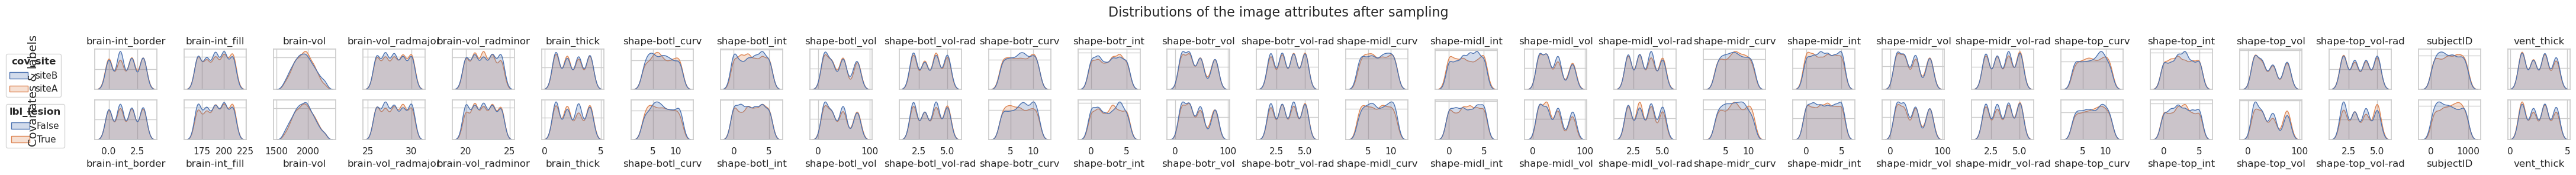

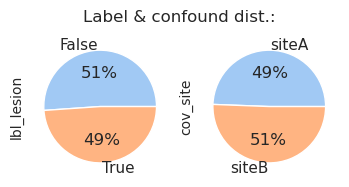

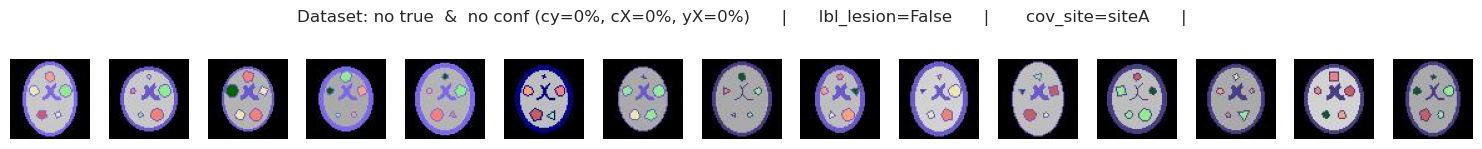

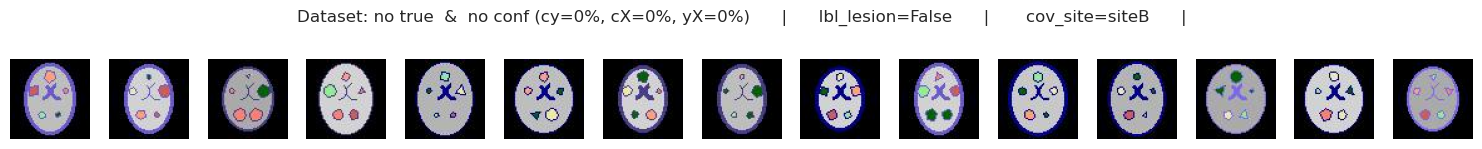

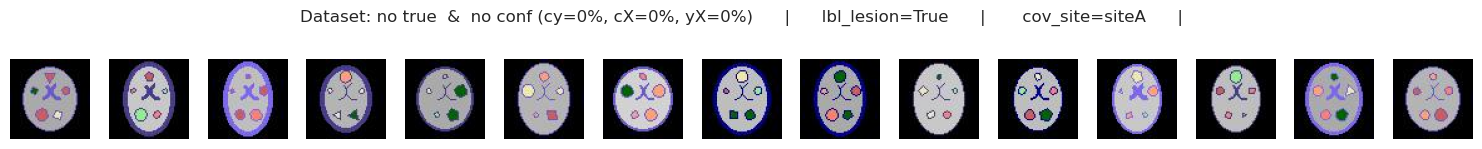

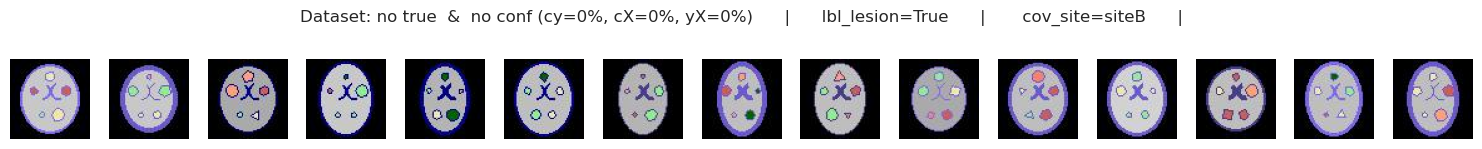

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: FULL true & no conf (cy=0%, cX=0%, yX=100%)


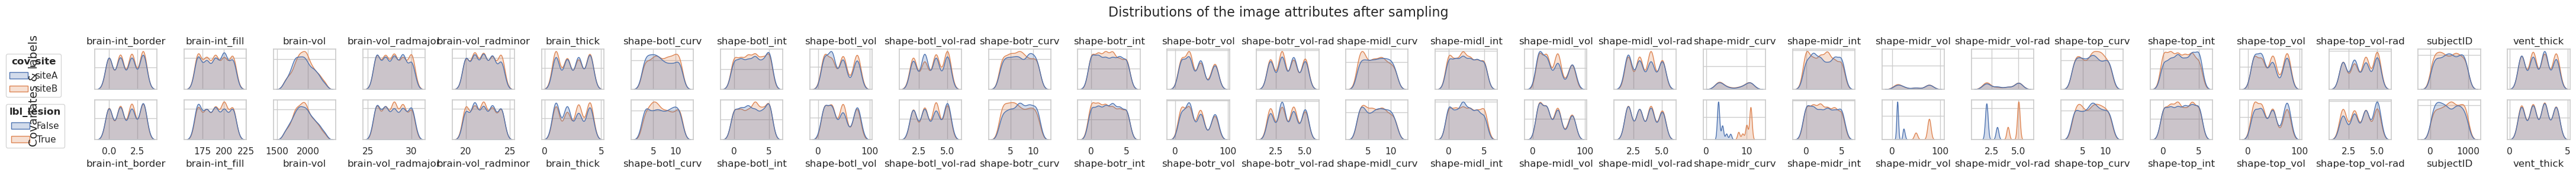

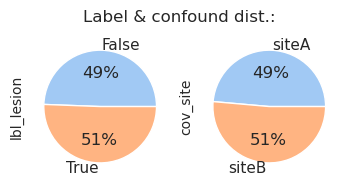

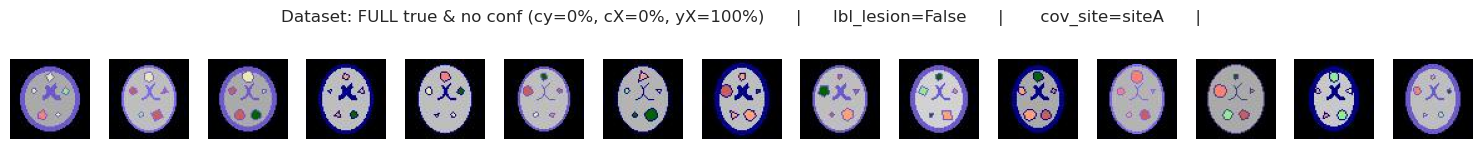

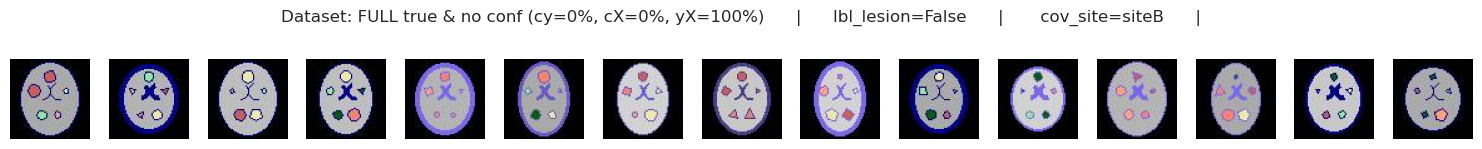

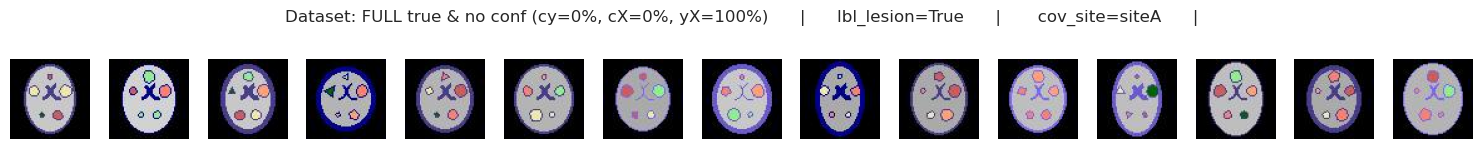

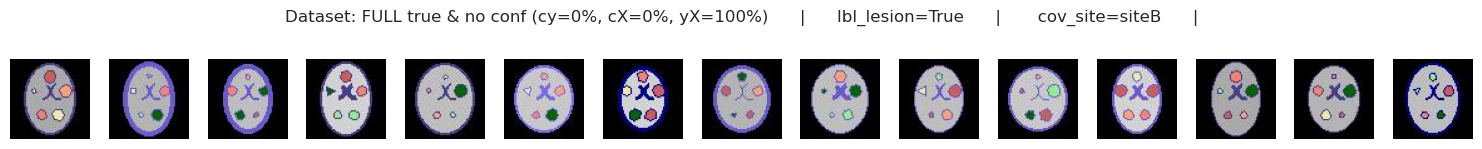

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: low true & HIGH conf (cy=25%, cX=25%, yX=75%)


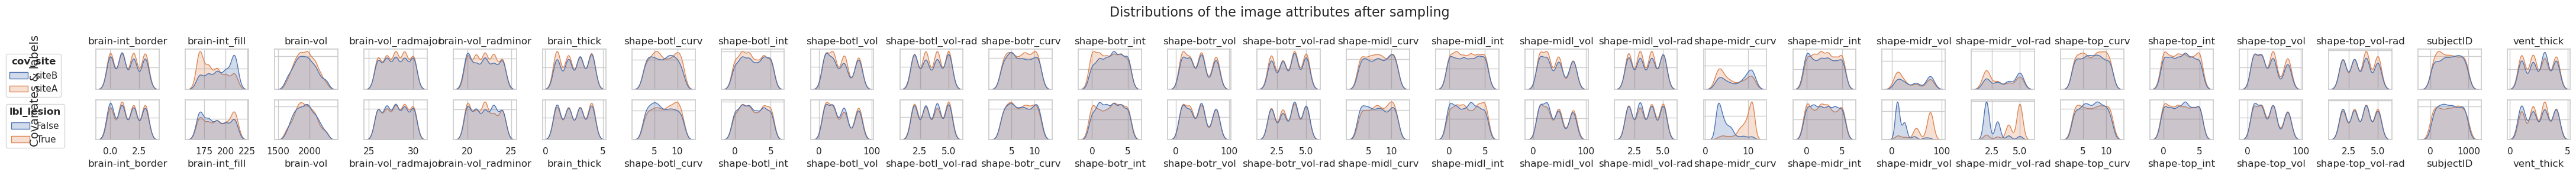

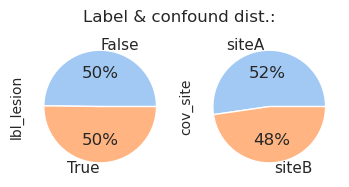

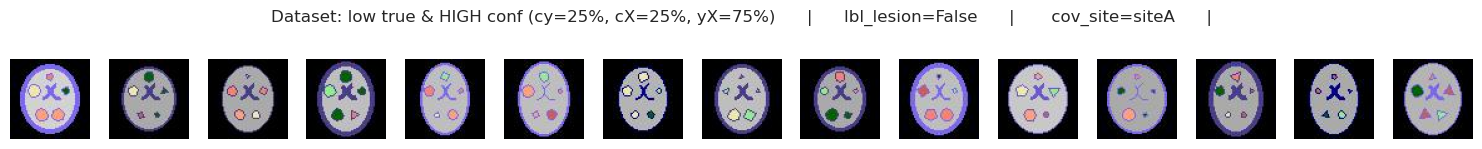

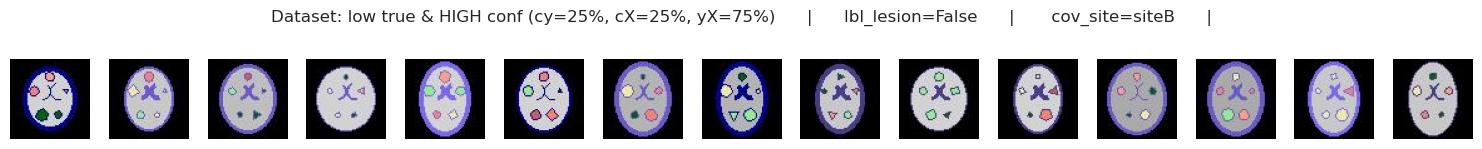

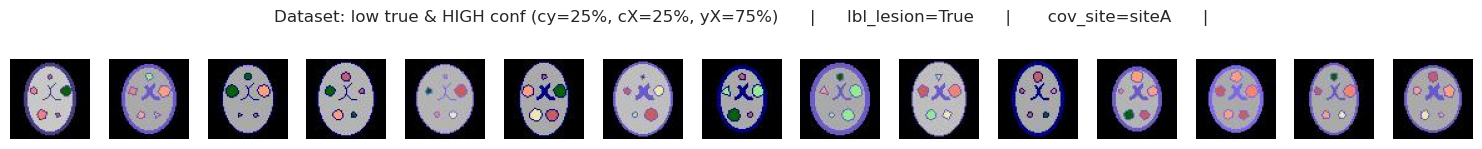

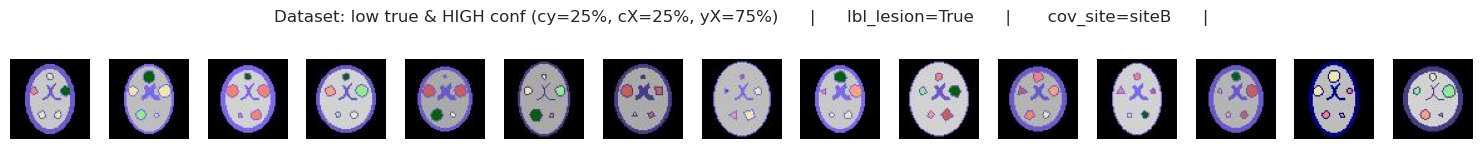

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: HIGH true & low conf (cy=75%, cX=75%, yX=25%)


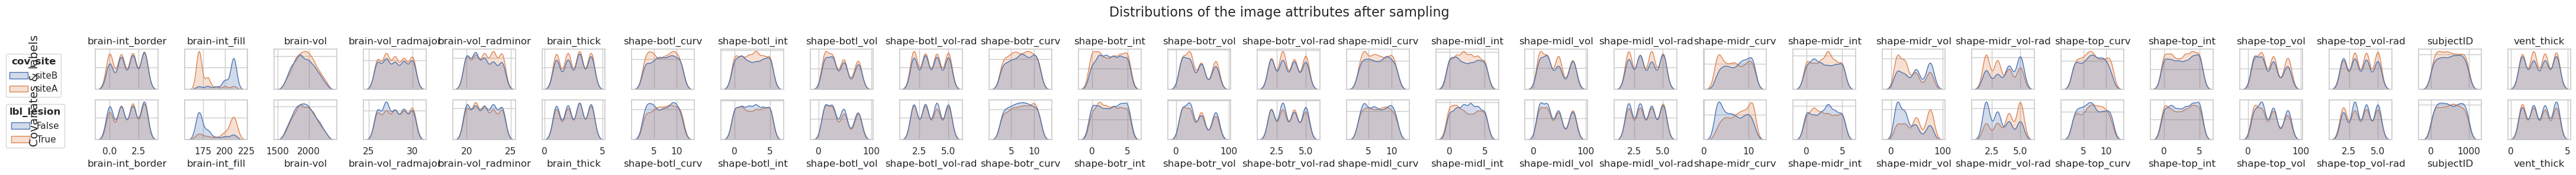

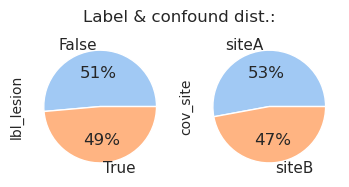

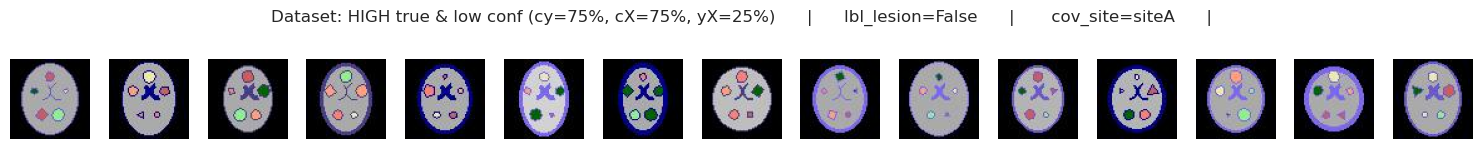

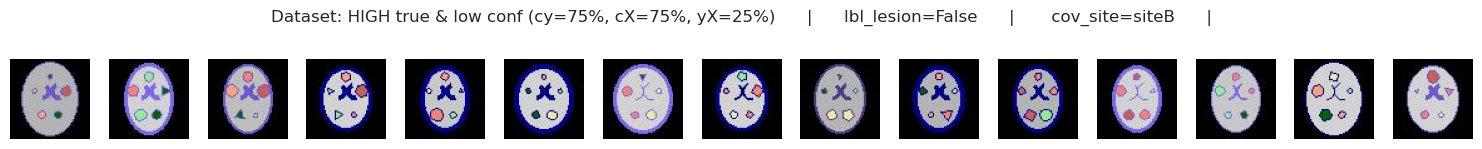

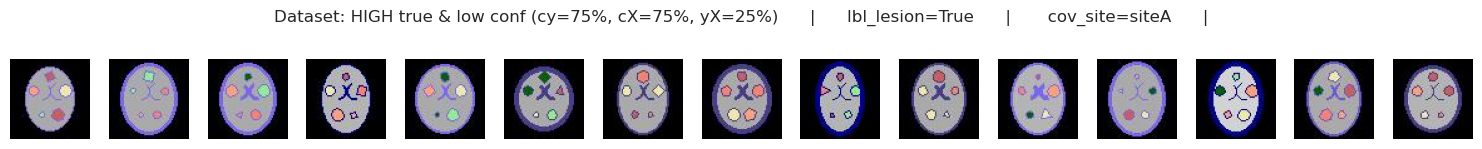

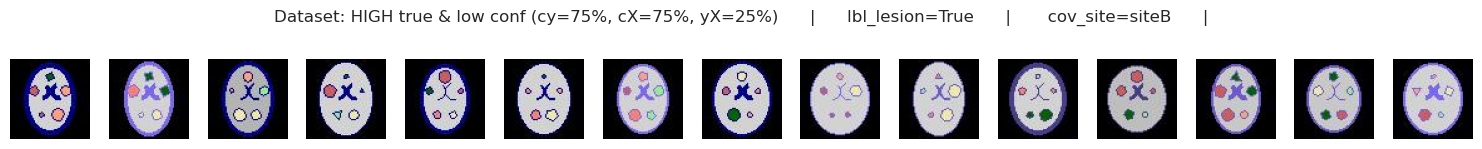

---------------------------------------------------------------------------------------------------------------------------------------------------------------- 
 Dataset: no true & FULL conf (cy=100%, cX=100%, yX=0%)


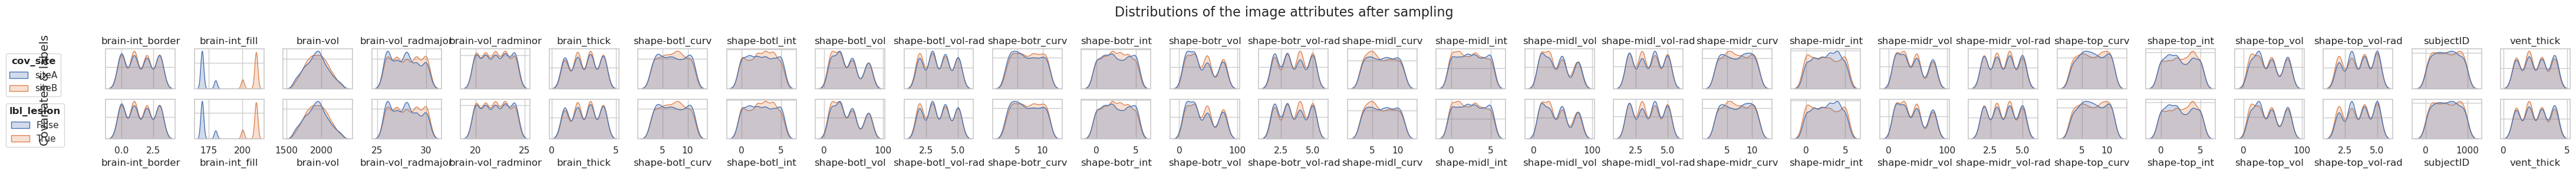

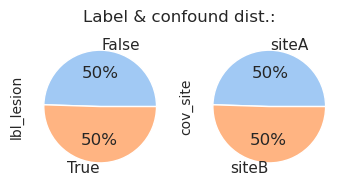

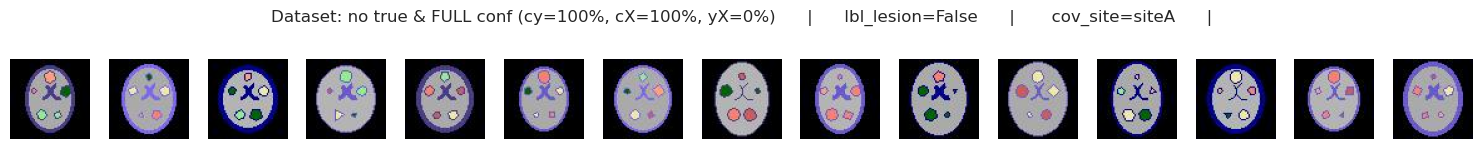

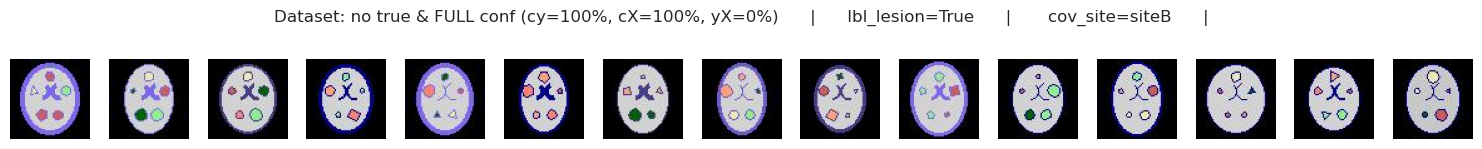

In [23]:
if VIZ_DISTS: 
    from utils.vizutils import plot_col_dists, plot_col_counts, show_images

    for config_type, (cy,cX,yX), rule in rules_to_viz_final:
        
        dataset_log = 'Dataset: '+ config_type + f' (cy={int(cy)}%, cX={int(cX)}%, yX={int(yX)}%)'
        print('--'*80, '\n', dataset_log)
        
        dataset_name = f'dataset/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}'
        if DATASET_SUFFIX: dataset_name += f'_{DATASET_SUFFIX}'
        df = pd.read_csv(f'{dataset_name}/{os.path.basename(dataset_name)}.csv') 
        # show the image attributes distributions
        cov_cols = df.filter(regex='^(cov_|lbl_)').columns
        attr_cols = df.filter(regex='^(?!(cov_|lbl_)).+').columns
        plot_col_dists(df, 
                    attr_cols=attr_cols, 
                    cov_cols=cov_cols, 
                    title=f"Distributions of the image attributes after sampling")
        plt.show()

        # show the label and confounder distributions
        plot_col_counts(df[cov_cols], title="Label & confound dist.:")
        plt.show()

        if VIZ_IMG_SAMPLES:

            n_imgs_per_row = 15

            # show 4 rows of images with different combinations of covariate and label states
            # df = pd.read_csv(f'{dataset}/toybrains_n{N_SAMPLES}_{basefilename}_cy{cy}-cX{cX}-yX{yX}.csv')
            for (lbl, cov), dfi in df.groupby(['lbl_lesion', 'cov_site']):
                # sample n_imgs_per_row 
                samples = dfi.sample(n_imgs_per_row, replace=False, random_state=None).index.values
                img_files = [f"{dataset_name}/images/{s:05}.jpg" for s in samples]
                # print(lbl, cov, img_files)
                show_images(img_files=img_files,
                            n_cols=n_imgs_per_row, n_rows=1,
                            title=f"{dataset_log}      |      lbl_lesion={lbl}      |       cov_site={cov}      |")
                plt.show()


#### See the configured associations (CA)

In [ ]:
if VIZ_BASELINE:
    metric_name = 'balanced_accuracy'
    # load all baseline results
    bl_results = [pd.read_csv(f) for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/LR/default/run.csv')]
    print(f'Found {len(bl_results)} baseline result tables.')

    # load it all in a dataframe
    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion'],
                             'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()

    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})
    cmap = {r'$CA_{total}$':'steelblue',
            r'$CA_{conf}$':'indianred',
            r'$CA_{true}$':'forestgreen'}
        
    display(df_model.info())
    display(df_model.tail())

Found 125 baseline result tables.
All results are shown in percentage (%)
<class 'pandas.core.frame.DataFrame'>
Index: 625 entries, toybrains_n5000_lblmidr-consite_cy000-cX000-yX000 to toybrains_n5000_lblmidr-consite_cy100-cX100-yX100
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   $CA_{total}$  625 non-null    int64
 1   $CA_{conf}$   625 non-null    int64
 2   $CA_{true}$   625 non-null    int64
dtypes: int64(3)
memory usage: 19.5+ KB


None

inp                                                $CA_{total}$  $CA_{conf}$  \
dataset                                                                        
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100           100          100   
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100           100          100   
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100           100          100   
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100           100          100   
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100           100          100   

inp                                                $CA_{true}$  
dataset                                                         
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100          100  
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100          100  
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100          100  
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100          100  
toybrains_n5000_lblmidr-consite_cy100-cX100-yX100          100

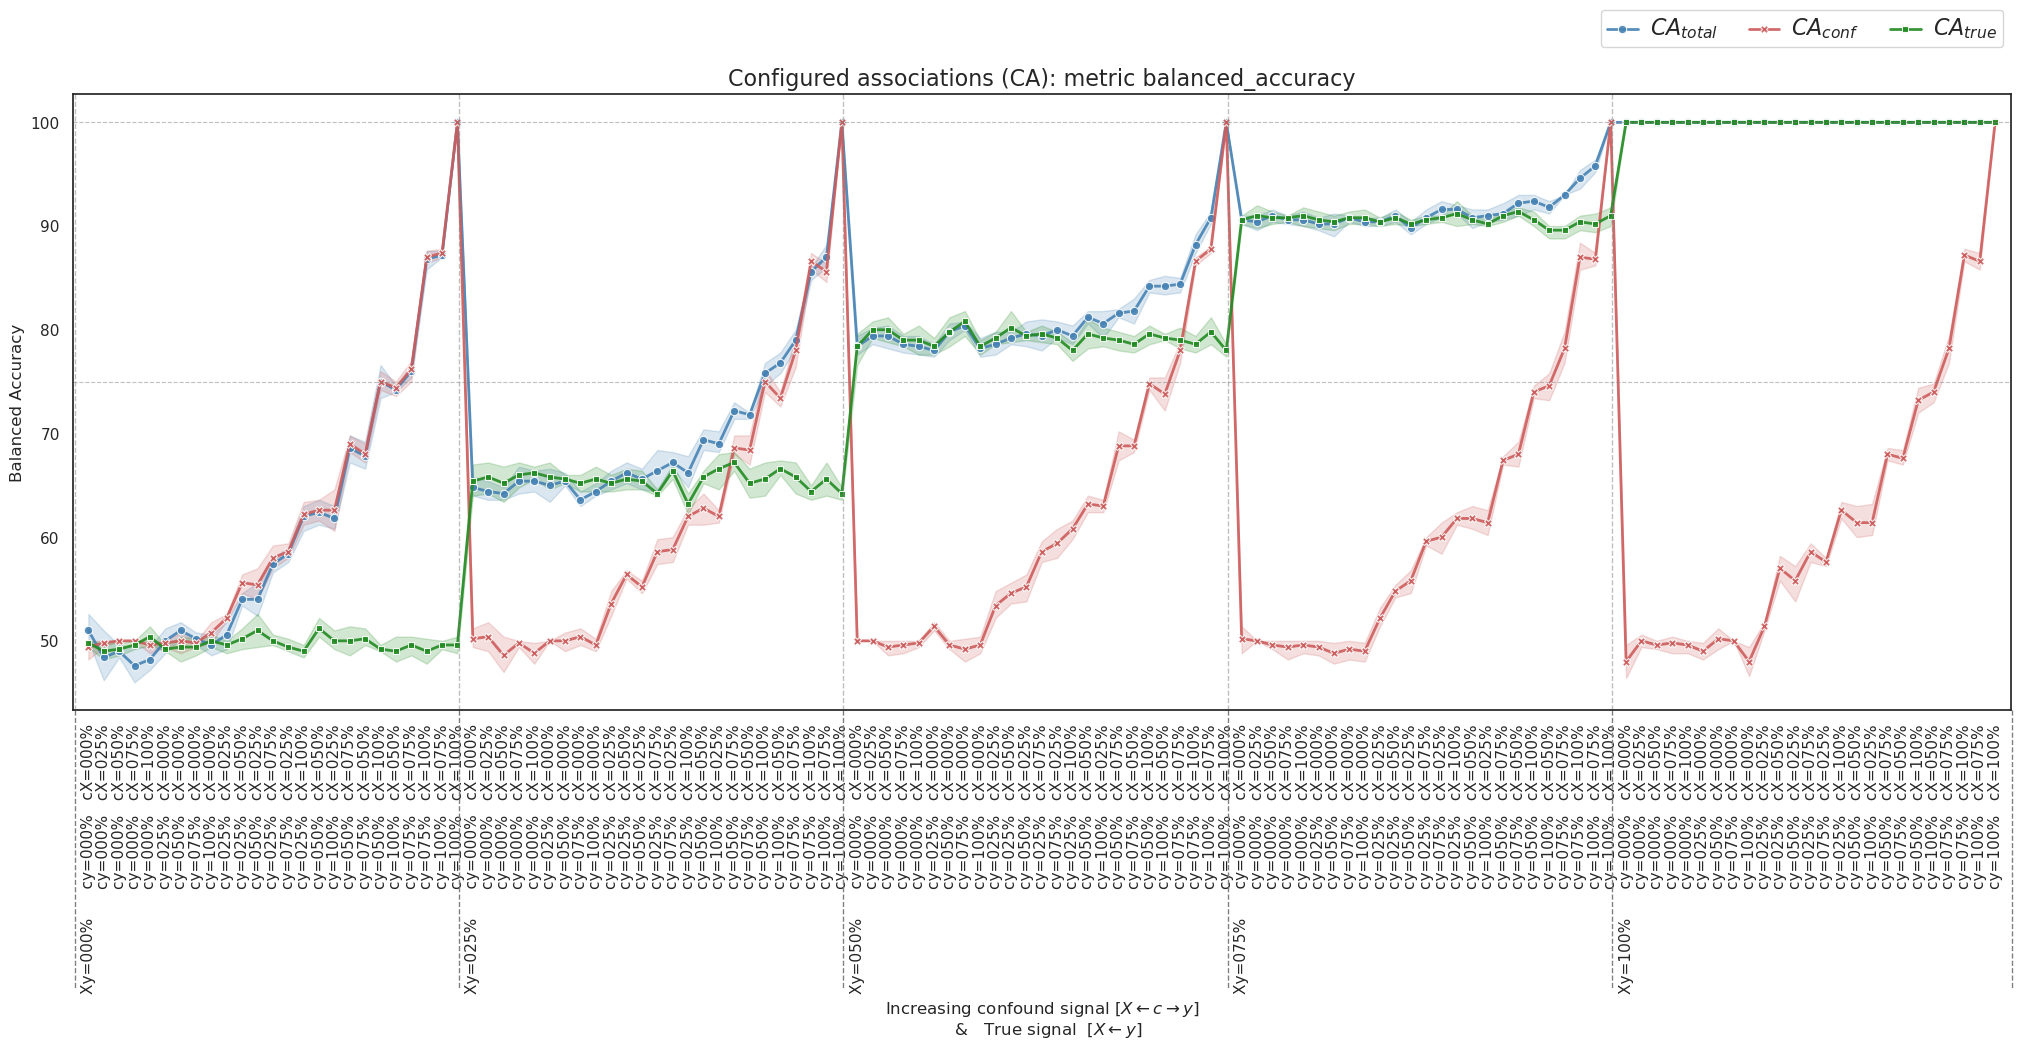

In [ ]:
if VIZ_BASELINE:
    # plot the configured associations for all datasets
    viz_contrib_table_2(df_model, metric_name=metric_name, cmap=cmap,
                        title=f'Configured associations (CA): metric {metric_name}')
    plt.show()

Found n=125 baseline results.
All results are shown in percentage (%)


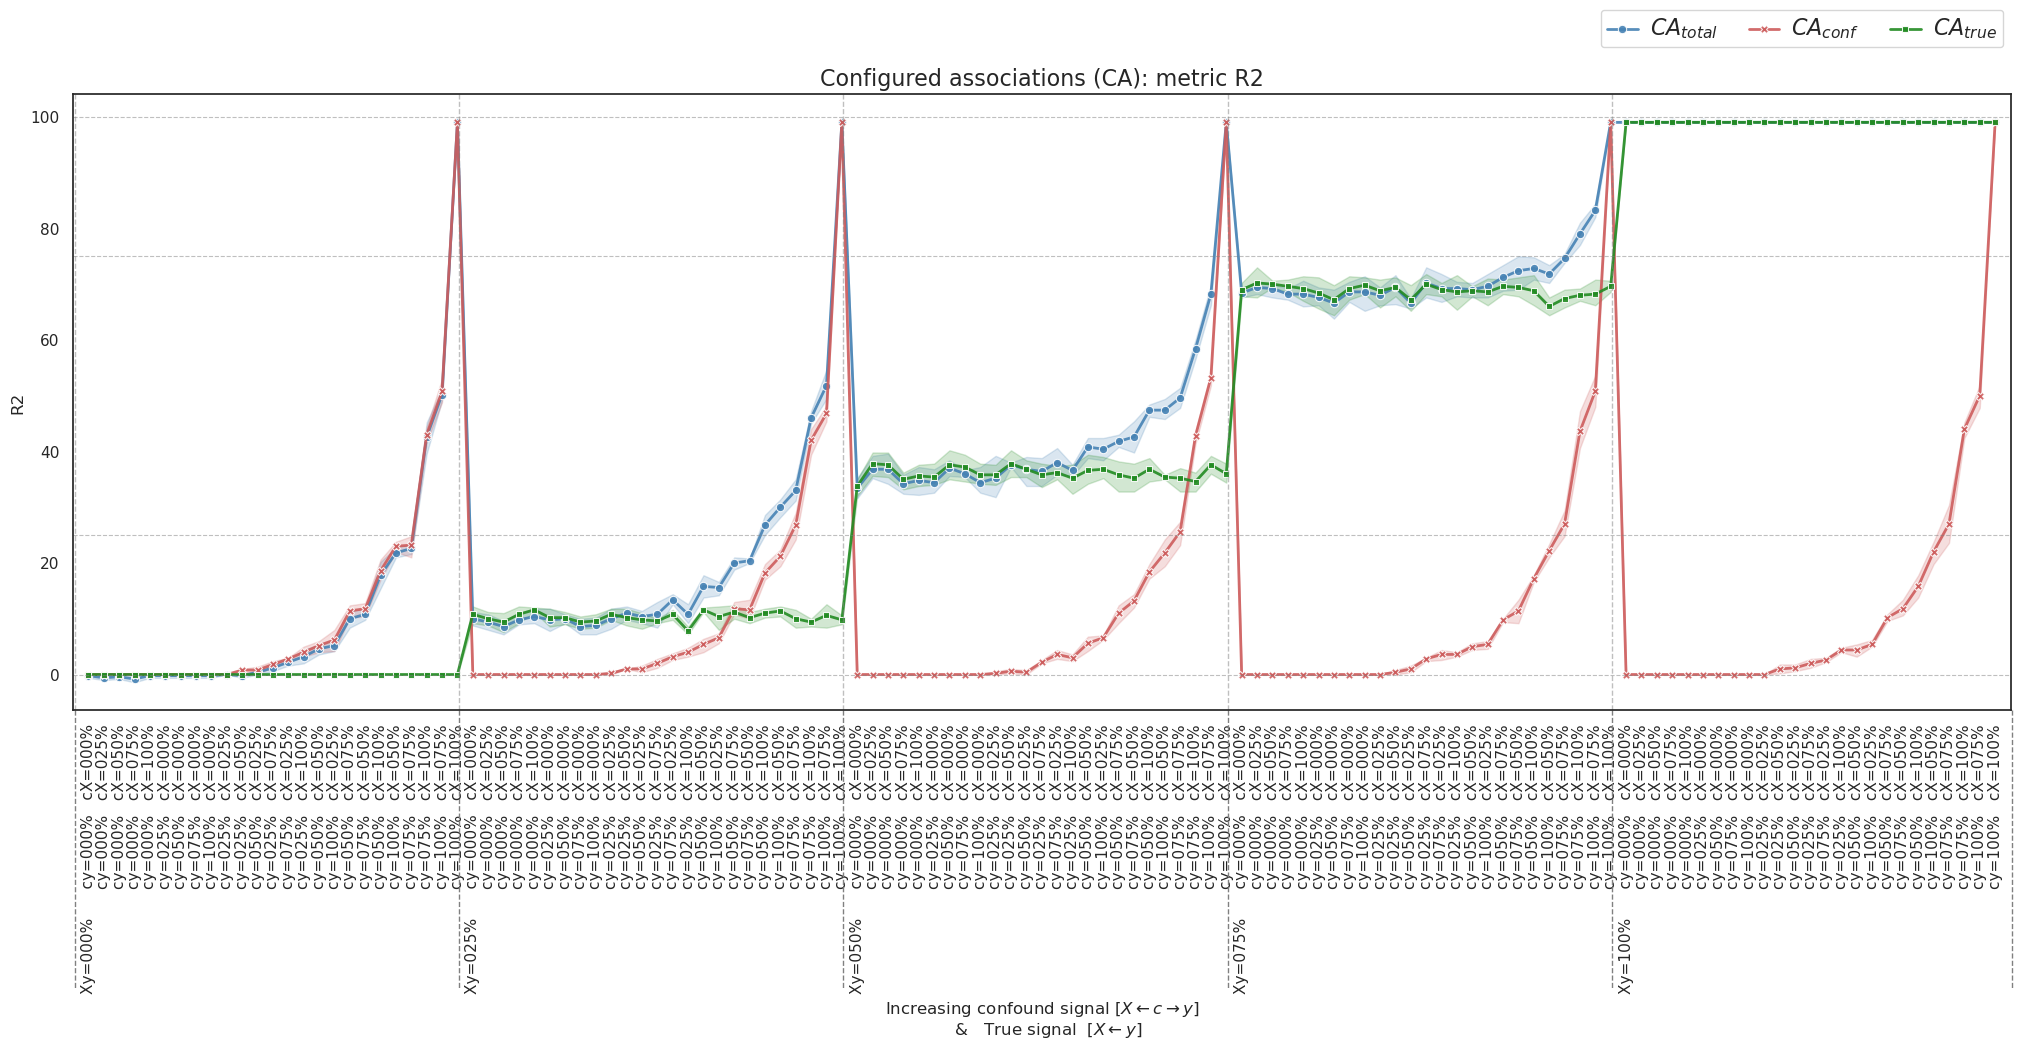

In [ ]:
# plot baseline results if generated
if VIZ_BASELINE:
    metric_name = 'r2'

    # load all baseline results
    bl_results = [pd.read_csv(f) for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/LR/default/run.csv')]
    print(f'Found n={len(bl_results)} baseline results.')

    # load it all in a dataframe
    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion'], 
                             'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()
    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})    
    
    cmap={r'$CA_{total}$':'steelblue', r'$CA_{conf}$':'indianred',  r'$CA_{true}$':'forestgreen'}

    # display(df_model.info())  
    # display(df_model.tail(10))    
    
    # plot the configured associations for all datasets
    viz_contrib_table_2(df_model, metric_name=metric_name, cmap=cmap,
                        title=f'Configured associations (CA): metric {metric_name.upper()}')
    plt.show()

Found n=125 baseline results.
All results are shown in percentage (%)


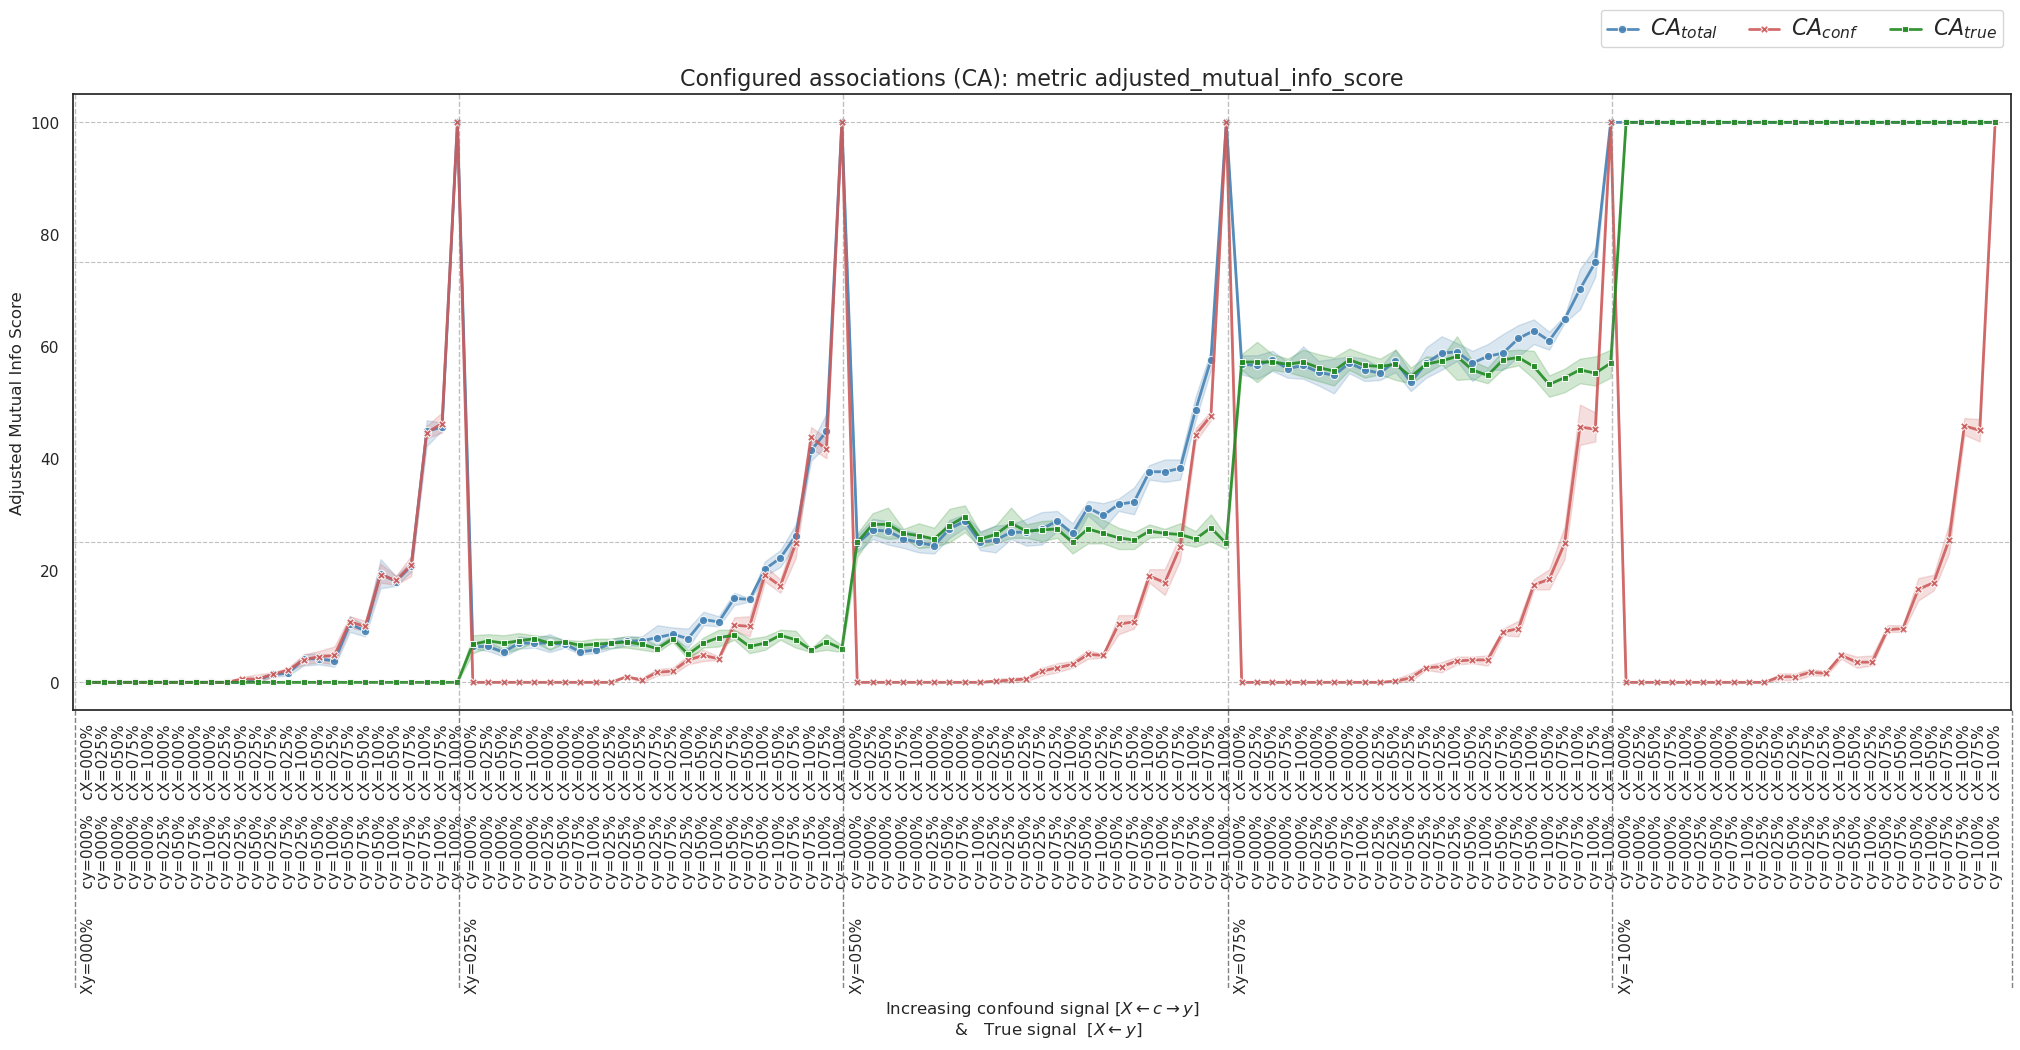

In [ ]:
# plot baseline results if generated
if VIZ_BASELINE:
    metric_name = 'adjusted_mutual_info_score'

    # load all baseline results
    bl_results = [pd.read_csv(f) for f in glob(f'dataset/toybrains_n{N_SAMPLES}_{basefilename}*/baseline_results/LR/default/run.csv')]
    print(f'Found n={len(bl_results)} baseline results.')

    # load it all in a dataframe
    df_model = show_contrib_table(
                bl_results, 
                avg_over_trials=False,
                filter_rows={'out':['lbl_lesion'], 
                             'inp':['attr_all', 'attr_brain-int_fill', 'attr_shape-midr_curv, shape-midr_vol-rad']},
                filter_cols=[f'score_test_{metric_name}']
                )
    df_model = df_model.data.unstack(level='inp').reset_index(level=["out", "trial"], drop=True)
    # drop the top level of the column index
    df_model.columns = df_model.columns.droplevel()
    df_model = df_model.rename(columns={'attr_all': r'$CA_{total}$', 
                                        'attr_brain-int_fill':r'$CA_{conf}$', 
                                        'attr_shape-midr_curv, shape-midr_vol-rad':r'$CA_{true}$'})    
    
    cmap={r'$CA_{total}$':'steelblue', r'$CA_{conf}$':'indianred',  r'$CA_{true}$':'forestgreen'}

    # display(df_model.info())  
    # display(df_model.tail(10))    
    
    # plot the configured associations for all datasets
    viz_contrib_table_2(df_model, metric_name=metric_name, cmap=cmap,
                        title=f'Configured associations (CA): metric {metric_name}')
    plt.show()

In [1]:
td = datetime.now()-start_time
print("Notebook finished in {}min : {}sec".format(td.seconds//60, td.seconds%60))

NameError: name 'datetime' is not defined